In [2]:
import time
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import torchvision.transforms as transforms

from torchsummary import summary
import copy

Kept the following code block for reference. We don't use `torch.quantization` - no quantization in general. With quantization, we could go very low in precision (e.g., int8), see [DoReFa](https://arxiv.org/pdf/1606.06160), for example.

We also don't use [Automatic Mixed Precision](https://pytorch.org/docs/stable/amp.html).

For now, we just go from float64 down to float16 as a first step.


In [3]:
print("Supported engines:", torch.backends.quantized.supported_engines)
print("Currently active quantized engine:", torch.backends.quantized.engine)
# torch.backends.quantized.engine = "qnnpack"
print("Now active quantized engine:", torch.backends.quantized.engine)

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Currently active device:", device)

Supported engines: ['none', 'onednn', 'x86', 'fbgemm']
Currently active quantized engine: x86
Now active quantized engine: x86
Currently active device: cuda


In [4]:
EPOCHS = 3
K_FOLDS = 5
MOMENTUM = 0.9
BATCH_SIZE = 256 
LEARNING_REATE = 0.01
DTYPES = [torch.float64, torch.float32, torch.float16]

In [9]:
class MLP(nn.Module):
	def __init__(self):
		super().__init__()
		# Linear layers & ReLU are separate for fusing when quantizing (if someone wants to implement that)
		# MNIST => 28x28=784
		# Linear = fully connected, y=xA^T+b
		# ReLU = activation for non-linearity
		# Output is 10 logits ("logit" = raw output of a linear layer = pre-activation) used later with CrossEntropyLoss
		# self.fc1 = nn.Linear(784, 128)
		# self.relu1 = nn.ReLU()
		# self.fc2 = nn.Linear(128, 64)
		# self.relu2 = nn.ReLU()
		# self.fc3 = nn.Linear(64, 10)

		n = 16 
		self.fc1 = nn.Linear(784, n)
		self.relu1 = nn.ReLU()
		self.fc2 = nn.Linear(n, n)
		self.relu2 = nn.ReLU()
		self.fc3 = nn.Linear(n, 10)

	def forward(self, x):
		# 28x28 MNIST images are flattened into 784-dim vectors
		x = x.view(x.size(0), -1)  # [batchSize,1,28,28] to [batchSize,784]
		x = self.fc1(x)
		x = self.relu1(x)
		x = self.fc2(x)
		x = self.relu2(x)
		x = self.fc3(x)
		return x

summary(MLP());

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            12,560
├─ReLU: 1-2                              --
├─Linear: 1-3                            272
├─ReLU: 1-4                              --
├─Linear: 1-5                            170
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0


In [302]:
def trainEpoch(model, loader, criterion, optimizer, device="cpu", dtype=torch.float32):
	model.train()
	running_loss = 0.0
	t = 0.0
	for images, labels in loader:

		images = images.to(device, dtype=dtype)  # Adapt input data to precision
		labels = labels.to(device)  # Labels stay as integer type (LongTensor)

		optimizer.zero_grad()

		t0 = time.time()
		outputs = model(images)
		loss = criterion(outputs, labels)
		t += time.time() - t0

		loss.backward()
		optimizer.step()

		running_loss += loss.item()
	return running_loss / len(loader), t


def evaluate(model, loader, device="cpu", dtype=torch.float32):
	model.eval()
	correct, total = 0, 0
	t = 0.0
	with torch.no_grad():
		for images, labels in loader:
			images = images.to(device, dtype=dtype)
			labels = labels.to(device)

			t0 = time.time()
			outputs = model(images)
			t += time.time() - t0
			_, predicted = outputs.max(dim=1)

			total += labels.size(0)
			correct += (predicted == labels).sum().item()
	return 100.0 * correct / total, t


In [303]:
# https://stackoverflow.com/questions/63746182/correct-way-of-normalizing-and-scaling-the-mnist-dataset
transform = transforms.Compose(
	[
		transforms.ToTensor(),
		transforms.Normalize((0.1307,), (0.3081,)),
	]
)
full_dataset = torchvision.datasets.FashionMNIST(
	root="./data",
	train=True,
	download=True,
	transform=transform,
)
train_set = torchvision.datasets.FashionMNIST(
	root="./data",
	train=True,
	download=True,
	transform=transform,
)
val_set = torchvision.datasets.FashionMNIST(
	root="./data",
	train=False,
	download=True,
	transform=transform,
)
train_loader = torch.utils.data.DataLoader(
	train_set,
	batch_size=BATCH_SIZE,
	shuffle=True,
)
val_loader = torch.utils.data.DataLoader(
	val_set,
	batch_size=BATCH_SIZE,
	shuffle=False,
)

In [304]:
current_dtype = torch.float32

model = MLP().to(device, dtype=current_dtype)
# Same dtype necessary here for CrossEntropyLoss? (I mean it is a subclasses of nn.Module so...)
criterion = nn.CrossEntropyLoss().to(device, dtype=current_dtype)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_REATE, momentum=MOMENTUM)

# train_start = time.time()
total_time = 0.0
acc = 0.0
EPOCHS = 5 
for epoch in range(EPOCHS):
	loss_val, train_duration = trainEpoch(
		model,
		train_loader,
		criterion,
		optimizer,
		device=device,
		dtype=current_dtype,
	)
	acc_val, _ = evaluate(model, val_loader, device=device, dtype=current_dtype)
	acc += acc_val

	total_time += train_duration

	print(
		f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss_val:.4f}, Val Acc: {acc_val:.2f}%"
	)

final_acc, eval_duration = evaluate(model, val_loader, device=device, dtype=current_dtype)
print(f'fp32 train: acc: {acc / EPOCHS:.2f}, t: {total_time / EPOCHS:.3e}')
print(f'fp32 eval : acc: {final_acc:.2f}, t: {eval_duration / EPOCHS:.3e}')

digits = list(range(15)) 
for d in digits:
	m = copy.deepcopy(model)
	with torch.no_grad():
		for param in m.parameters():
			param.copy_(torch.round(param, decimals=d))

	final_acc, eval_duration = evaluate(m, val_loader, device=device, dtype=current_dtype)
	print(f'round {d}: acc: {final_acc:.2f}, t: {eval_duration / EPOCHS:.3e}')


Epoch 1/5, Loss: 0.6618, Val Acc: 83.45%
Epoch 2/5, Loss: 0.4088, Val Acc: 84.77%
Epoch 3/5, Loss: 0.3617, Val Acc: 84.81%
Epoch 4/5, Loss: 0.3348, Val Acc: 86.65%
Epoch 5/5, Loss: 0.3119, Val Acc: 86.73%
fp32 train: acc: 85.28, t: 1.549e-01
fp32 eval : acc: 86.73, t: 4.721e-03
round 0: acc: 10.00, t: 5.148e-03
round 1: acc: 11.95, t: 3.111e-03
round 2: acc: 86.50, t: 2.661e-03
round 3: acc: 86.66, t: 3.157e-03
round 4: acc: 86.73, t: 5.015e-03
round 5: acc: 86.73, t: 3.488e-03
round 6: acc: 86.73, t: 4.282e-03
round 7: acc: 86.73, t: 6.564e-03
round 8: acc: 86.73, t: 4.457e-03
round 9: acc: 86.73, t: 3.810e-03
round 10: acc: 86.73, t: 4.818e-03
round 11: acc: 86.73, t: 3.926e-03
round 12: acc: 86.73, t: 3.595e-03
round 13: acc: 86.73, t: 3.701e-03
round 14: acc: 86.73, t: 4.340e-03


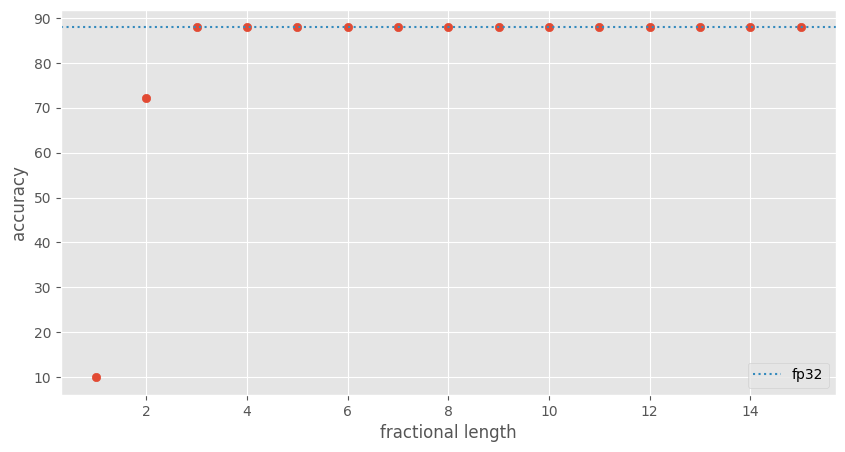

In [292]:
# fp32 train: acc: 85.71, t: 1.325e-01
# fp32 eval : acc: 87.89, t: 1.297e-03
# round 0: acc: 10.00, t: 1.448e-03
# round 1: acc: 72.21, t: 4.744e-04
# round 2: acc: 87.91, t: 3.079e-03
# round 3: acc: 87.89, t: 1.404e-03
# round 4: acc: 87.89, t: 1.559e-03
# round 5: acc: 87.89, t: 2.030e-03
# round 6: acc: 87.89, t: 6.460e-04
# round 7: acc: 87.89, t: 7.594e-04
# round 8: acc: 87.89, t: 3.058e-03
# round 9: acc: 87.89, t: 2.121e-03
# round 10: acc: 87.89, t: 1.085e-03
# round 11: acc: 87.89, t: 1.363e-03
# round 12: acc: 87.89, t: 7.436e-04
# round 13: acc: 87.89, t: 1.323e-03
# round 14: acc: 87.89, t: 6.407e-04

baseline = 87.89
accs =  [10.00, 72.21, 87.91, 87.89, 87.89, 87.89, 87.89, 87.89, 87.89, 87.89, 87.89, 87.89, 87.89, 87.89, 87.89]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(accs)) + 1, accs)
plt.axhline(baseline, c=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], linestyle=':', label='fp32')
plt.ylabel('accuracy')
plt.xlabel('fractional length')
plt.legend()
# plt.rcParams['axes.prop_cycle'][:]



In [ ]:
# with torch.no_grad():
from itertools import cycle
descr = ['weigth', 'bias']
descr = cycle(descr)

weights = []
biases = []

for i, param in enumerate(model.parameters()):
	print(next(descr))
	print(i, param.mean().item(), param.std().item())
	if i % 2 == 0:
		weights.append(param.detach().cpu().numpy().reshape(-1))
	else:
		biases.append(param.detach().cpu().numpy().reshape(-1))
	# vals.append(param)
	# print(param)
	# break

weigth
0 -0.0017361893551424146 0.027307534590363503
bias
1 0.007253519259393215 0.02667062170803547
weigth
2 0.003100864589214325 0.06126169115304947
bias
3 0.005207732319831848 0.05275493115186691
weigth
4 -4.741866359836422e-05 0.13254256546497345
bias
5 -0.027753664180636406 0.1299898773431778


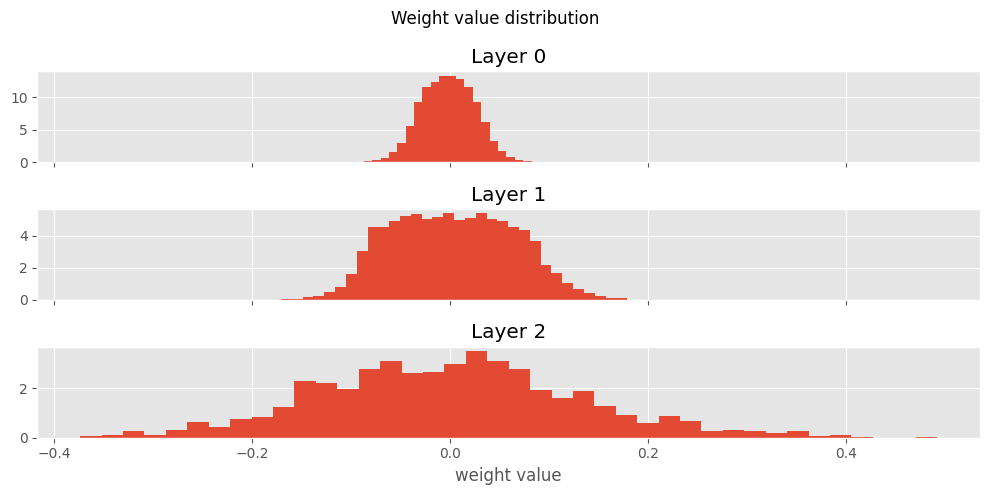

In [171]:
plt.style.use('ggplot')
fig, axes = plt.subplots(3, 1, figsize=[10, 5], sharex=True)
layer_names = ['input', 'hidden', 'output']
for i, ax in enumerate(axes.flatten()):
    ax.hist(weights[i], density=True, bins=40)
    ax.set_title(f'Layer {i}')

plt.xlabel('weight value')
plt.suptitle('Weight value distribution')
plt.tight_layout()
# plt.hist(np.concatenate([w for w in weights]), bins=100);

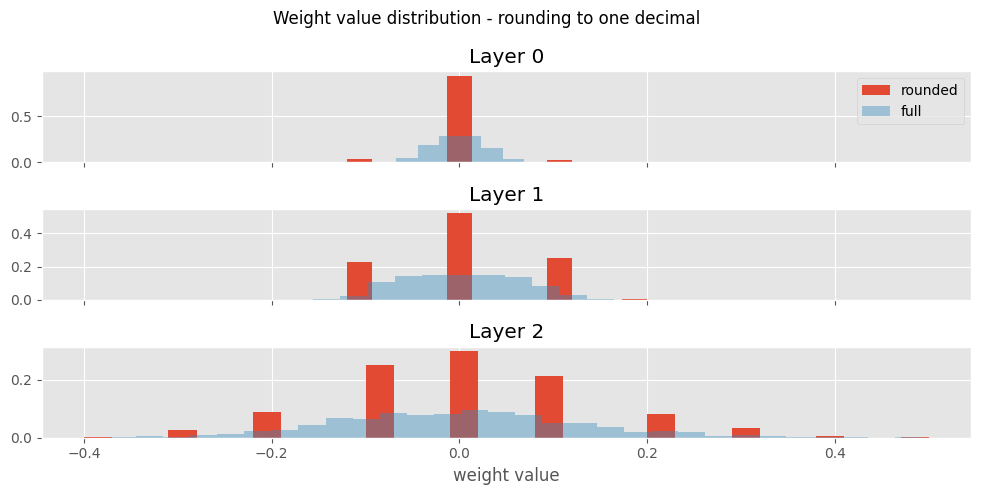

In [ ]:
plt.style.use('ggplot')
fig, axes = plt.subplots(3, 1, figsize=[10, 5], sharex=True)
layer_names = ['input', 'hidden', 'output']
for i, ax in enumerate(axes.flatten()):
    
    x = weights[i]
    rounded = np.round(x, 1)
    n = np.unique(rounded).shape[0] * 3 
    weight = np.ones_like(x) / len(x)

    ax.hist(np.round(x, 1), bins=n, weights=weight, label='rounded')
    ax.hist(x, bins=n, alpha=0.4, weights=weight, label='full')
    ax.set_title(f'Layer {i}')

plt.xlabel('weight value')
plt.suptitle('Weight value distribution - rounding to one decimal')
axes[0].legend(loc='upper right')
plt.tight_layout()

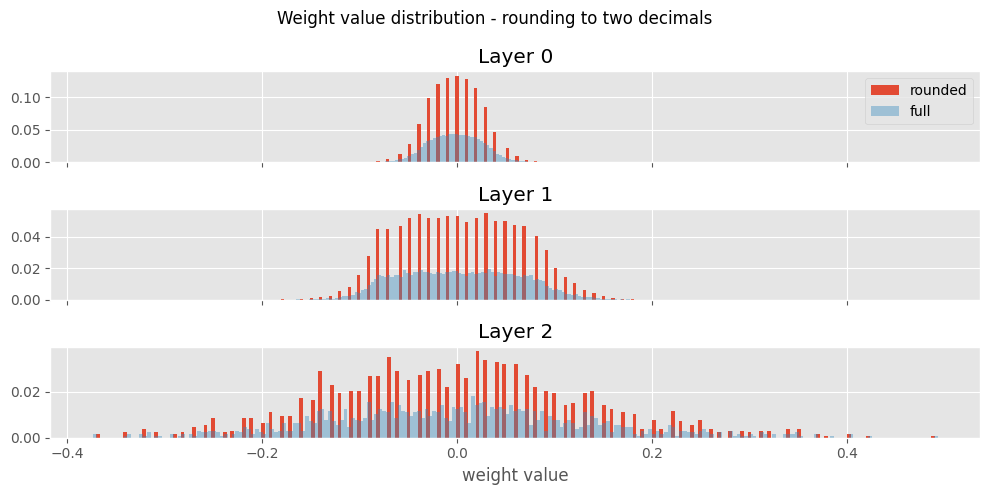

In [244]:
plt.style.use('ggplot')
fig, axes = plt.subplots(3, 1, figsize=[10, 5], sharex=True)
layer_names = ['input', 'hidden', 'output']
for i, ax in enumerate(axes.flatten()):
    # n = int(np.sqrt(len(weights[i])))
    x = weights[i]
    rounded = np.round(x, 2)
    n = np.unique(rounded).shape[0] * 3
    weight = np.ones_like(x) / len(x)
    
    ax.hist(np.round(x, 2), bins=n, weights=weight, label='rounded')
    ax.hist(x, bins=n, alpha=0.4, weights=weight, label='full')
    ax.set_title(f'Layer {i}')

plt.xlabel('weight value')
plt.suptitle('Weight value distribution - rounding to two decimals')
axes[0].legend(loc='upper right')
plt.tight_layout()

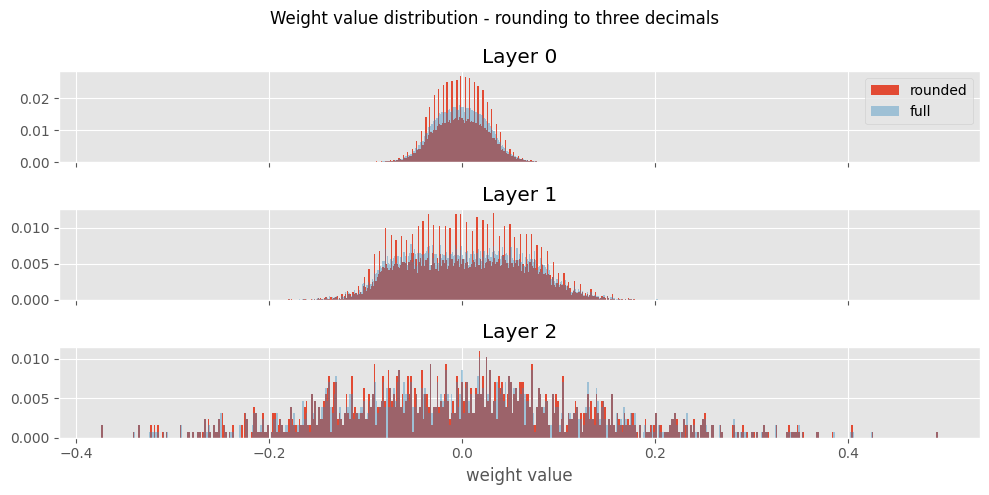

In [246]:
plt.style.use('ggplot')
fig, axes = plt.subplots(3, 1, figsize=[10, 5], sharex=True)
layer_names = ['input', 'hidden', 'output']
for i, ax in enumerate(axes.flatten()):
    n = int(np.sqrt(len(weights[i])))
    
    x = weights[i]
    rounded = np.round(x, 3)
    n = np.unique(rounded).shape[0]
    weight = np.ones_like(x) / len(x)
    
    ax.hist(np.round(x, 3), bins=n, weights=weight, label='rounded')
    ax.hist(x, bins=n, alpha=0.4, weights=weight, label='full')
    ax.set_title(f'Layer {i}')

plt.xlabel('weight value')
plt.suptitle('Weight value distribution - rounding to three decimals')
axes[0].legend(loc='upper right')
plt.tight_layout()

## Training from scratch with decreasing precision

This should answer the question: _How does changing the precision during training affect the final model’s accuracy and performance?_


In [ ]:
fold_size = len(full_dataset) // K_FOLDS
indices = list(range(len(full_dataset)))
np.random.shuffle(indices)

results = {}
timings = {}

for current_dtype in DTYPES:
	print("\n==============================================")
	print(f"Training with dtype = {current_dtype}")
	fold_accuracies = []
	train_times = []
	eval_times = []

	for fold in range(K_FOLDS):
		print(f"\n--- Fold {fold+1}/{K_FOLDS} ---")

		val_indices = indices[fold * fold_size : (fold + 1) * fold_size]
		train_indices = indices[: fold * fold_size] + indices[(fold + 1) * fold_size :]

		train_subset = Subset(full_dataset, train_indices)
		val_subset = Subset(full_dataset, val_indices)

		train_loader = torch.utils.data.DataLoader(
			train_subset, batch_size=BATCH_SIZE, shuffle=True
		)
		val_loader = torch.utils.data.DataLoader(
			val_subset, batch_size=BATCH_SIZE, shuffle=False
		)

		model = MLP().to(device, dtype=current_dtype)
		# Same dtype necessary here for CrossEntropyLoss? (I mean it is a subclasses of nn.Module so...)
		criterion = nn.CrossEntropyLoss().to(device, dtype=current_dtype)
		optimizer = optim.SGD(model.parameters(), lr=LEARNING_REATE, momentum=MOMENTUM)

		# train_start = time.time()
		for epoch in range(EPOCHS):
			loss_val, train_duration = trainEpoch(
				model,
				train_loader,
				criterion,
				optimizer,
				device=device,
				dtype=current_dtype,
			)
			acc_val, _ = evaluate(model, val_loader, device=device, dtype=current_dtype)
			print(
				f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss_val:.4f}, Val Acc: {acc_val:.2f}%"
			)
		# train_end = time.time()
		# train_duration = train_end - train_start
		train_times.append(train_duration)

		# eval_start = time.time()
		final_acc, eval_duration = evaluate(model, val_loader, device=device, dtype=current_dtype)
		# eval_end = time.time()
		# eval_duration = eval_end - eval_start
		eval_times.append(eval_duration)

		fold_accuracies.append(final_acc)
		print(f"Fold {fold+1} accuracy: {final_acc:.2f}%")
		print(
			f"Training time: {train_duration:.2f}s | Inference time: {eval_duration:.2f}s"
		)

	avg_acc = sum(fold_accuracies) / K_FOLDS
	avg_train_time = sum(train_times) / K_FOLDS
	avg_eval_time = sum(eval_times) / K_FOLDS

	results[str(current_dtype)] = avg_acc
	timings[str(current_dtype)] = {
		"avg_train_time": avg_train_time,
		"avg_eval_time": avg_eval_time,
	}

print("\nAveraged results over 5 folds:")
for dtype_str, acc_val in results.items():
	print(f"{dtype_str}: {acc_val:.2f}%")

print("\nAverage timing per dtype:")
for dtype_str, t in timings.items():
	print(
		f"{dtype_str}: Train = {t['avg_train_time']:.2f}s, Eval = {t['avg_eval_time']:.2f}s"
	)


Training with dtype = torch.float64

--- Fold 1/5 ---
Epoch 1/3, Loss: 0.5107, Val Acc: 85.17%
Epoch 2/3, Loss: 0.3550, Val Acc: 85.94%
Epoch 3/3, Loss: 0.3127, Val Acc: 86.50%
Fold 1 accuracy: 86.50%
Training time: 0.42s | Inference time: 0.09s

--- Fold 2/5 ---
Epoch 1/3, Loss: 0.5191, Val Acc: 86.33%
Epoch 2/3, Loss: 0.3611, Val Acc: 87.94%
Epoch 3/3, Loss: 0.3191, Val Acc: 87.99%
Fold 2 accuracy: 87.99%
Training time: 0.43s | Inference time: 0.08s

--- Fold 3/5 ---
Epoch 1/3, Loss: 0.5167, Val Acc: 86.42%
Epoch 2/3, Loss: 0.3573, Val Acc: 86.20%
Epoch 3/3, Loss: 0.3166, Val Acc: 86.42%
Fold 3 accuracy: 86.42%
Training time: 0.41s | Inference time: 0.09s

--- Fold 4/5 ---
Epoch 1/3, Loss: 0.5216, Val Acc: 85.64%
Epoch 2/3, Loss: 0.3619, Val Acc: 87.28%
Epoch 3/3, Loss: 0.3207, Val Acc: 88.18%
Fold 4 accuracy: 88.18%
Training time: 0.40s | Inference time: 0.08s

--- Fold 5/5 ---
Epoch 1/3, Loss: 0.5197, Val Acc: 86.14%
Epoch 2/3, Loss: 0.3599, Val Acc: 87.28%
Epoch 3/3, Loss: 0.3180

In [ ]:
results = {
	"float64": 96.82,
	"float32": 96.76,
	"float16": 96.74,
}
df = pd.DataFrame(list(results.items()), columns=["Precision", "Accuracy"])
plt.figure(figsize=(8, 5), dpi=300)
plt.bar(df["Precision"], df["Accuracy"], color="#b9a4c6")
plt.title("Model Accuracies (Training and Inference)")
plt.xlabel("Precision Type")
plt.ylabel("Accuracy (%)")
plt.ylim(96.5, 97)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
timings = {
	"torch.float64": {"Train": 17.92, "Eval": 1.13},
	"torch.float32": {"Train": 17.20, "Eval": 1.05},
	"torch.float16": {"Train": 17.88, "Eval": 1.14},
}
timing_df = pd.DataFrame(timings).T.reset_index().rename(columns={"index": "Precision"})
timing_df = timing_df[["Precision", "Train", "Eval"]]
x = range(len(timing_df))
width = 0.35
plt.figure(figsize=(9, 5), dpi=300)
plt.bar(
	[i - width / 2 for i in x],
	timing_df["Train"],
	width=width,
	label="Train Time",
	color="#b9a4c6",
)
plt.bar(
	[i + width / 2 for i in x],
	timing_df["Eval"],
	width=width,
	label="Eval Time",
	color="#d2bfd8",
)
plt.xticks(x, timing_df["Precision"])
plt.title("Average Training and Inference Times")
plt.xlabel("Precision Type")
plt.ylabel("Time (sec)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Train on single (high) precision and test lower-precision inference effects (= inference-only testing)

This should show the effect of precision during inference after training a single model.

So the model is trained with float64 and then a **post-training precision reduction** is done.


In [ ]:
results = {
	"float64": [],
	"float32_eval_only": [],
	"float16_eval_only": [],
}

for fold in range(K_FOLDS):
	print(f"\n==============================================")
	print(f"Training Fold {fold+1}/{K_FOLDS} with dtype = float64")

	val_indices = indices[fold * fold_size : (fold + 1) * fold_size]
	train_indices = indices[: fold * fold_size] + indices[(fold + 1) * fold_size :]

	train_subset = Subset(full_dataset, train_indices)
	val_subset = Subset(full_dataset, val_indices)

	train_loader = torch.utils.data.DataLoader(
		train_subset, batch_size=BATCH_SIZE, shuffle=True
	)
	val_loader = torch.utils.data.DataLoader(
		val_subset, batch_size=BATCH_SIZE, shuffle=False
	)

	model = MLP().to(device, dtype=torch.float64)  # float64 only
	criterion = nn.CrossEntropyLoss().to(device, dtype=torch.float64)
	optimizer = optim.SGD(model.parameters(), lr=LEARNING_REATE, momentum=MOMENTUM)

	for epoch in range(EPOCHS):
		loss_val = trainEpoch(
			model,
			train_loader,
			criterion,
			optimizer,
			device=device,
			dtype=torch.float64,
		)
		acc_val = evaluate(model, val_loader, device=device, dtype=torch.float64)
		print(
			f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss_val:.4f}, Val Acc: {acc_val:.2f}%"
		)

	# float64 eval
	acc_float64 = evaluate(model, val_loader, device=device, dtype=torch.float64)
	results["float64"].append(acc_float64)
	print(f"Fold {fold+1} accuracy (float64): {acc_float64:.2f}%")

	################################################################################

	# Eval-only with float32
	model_float32 = model.to(dtype=torch.float32)
	acc_float32 = evaluate(
		model_float32, val_loader, device=device, dtype=torch.float32
	)
	results["float32_eval_only"].append(acc_float32)
	print(f"Fold {fold+1} accuracy (eval only, float32): {acc_float32:.2f}%")

	################################################################################

	# Eval-only with float16
	model_float16 = model.to(dtype=torch.float16)
	acc_float16 = evaluate(
		model_float16, val_loader, device=device, dtype=torch.float16
	)
	results["float16_eval_only"].append(acc_float16)
	print(f"Fold {fold+1} accuracy (eval only, float16): {acc_float16:.2f}%")


print("\nAveraged results over 5 folds:")
for key in results:
	avg = sum(results[key]) / K_FOLDS
	print(f"{key}: {avg:.2f}%")

In [ ]:
results = {
	"float64 (trained + eval)": 96.77,
	"float32 (eval only)": 96.77,
	"float16 (eval only)": 96.77,
}
df = pd.DataFrame(list(results.items()), columns=["Precision", "Accuracy"])
plt.figure(figsize=(8, 5), dpi=300)
plt.bar(df["Precision"], df["Accuracy"], color="#b9a4c6")
plt.title("Model Accuracies (Inference Only)")
plt.xlabel("Precision Type")
plt.ylabel("Accuracy (%)")
plt.ylim(96.5, 97)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()